<a href="https://colab.research.google.com/github/AliKayhanAtay/home-credit-default-risk/blob/main/home_credit_default_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
from google.colab import files

! pip install -q kaggle
files.upload();
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! mkdir /content/data
try:
  import os
  os.chdir('/content/data')
except:
  pass
! kaggle competitions download -c home-credit-default-risk;
! pip install lightgbm==3.0.0

Saving kaggle.json to kaggle.json
 92% 89.0M/96.7M [00:01<00:00, 49.4MB/s]
100% 96.7M/96.7M [00:01<00:00, 57.4MB/s]
 96% 73.0M/76.3M [00:02<00:00, 16.0MB/s]
100% 76.3M/76.3M [00:02<00:00, 31.1MB/s]
  0% 0.00/524k [00:00<?, ?B/s]
100% 524k/524k [00:00<00:00, 178MB/s]
 94% 256M/271M [00:05<00:00, 40.1MB/s]
100% 271M/271M [00:05<00:00, 51.4MB/s]
  0% 0.00/36.5k [00:00<?, ?B/s]
100% 36.5k/36.5k [00:00<00:00, 40.2MB/s]
 86% 49.0M/56.8M [00:01<00:00, 34.6MB/s]
100% 56.8M/56.8M [00:01<00:00, 47.1MB/s]
 86% 5.00M/5.81M [00:00<00:00, 6.24MB/s]
100% 5.81M/5.81M [00:00<00:00, 7.04MB/s]
 75% 27.0M/36.1M [00:00<00:00, 37.8MB/s]
100% 36.1M/36.1M [00:00<00:00, 73.5MB/s]
 75% 81.0M/109M [00:03<00:01, 14.6MB/s]
100% 109M/109M [00:04<00:00, 28.3MB/s] 
 68% 25.0M/36.8M [00:00<00:00, 32.5MB/s]
100% 36.8M/36.8M [00:00<00:00, 62.6MB/s]
     |████████████████████████████████| 1.8MB 7.6MB/s 
  Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from lightgbm import LGBMClassifier 

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, f1_score, classification_report, precision_score, recall_score, roc_auc_score, roc_curve

try:
  import os
  os.chdir('/content/data')
except: pass
import gc
gc.enable()

import functools
import warnings
warnings.filterwarnings("ignore")
pd.options.display.max_columns = 999
pd.options.display.max_rows = 150

from itertools import product
import pickle
import multiprocessing

n_cpu = multiprocessing.cpu_count()

In [ ]:
app_train = pd.read_csv('application_train.csv.zip')
app_test  = pd.read_csv('application_test.csv.zip')
app_test['TARGET'] = np.nan
app_train = pd.concat([app_train,app_test])

previous_application  = pd.read_csv('previous_application.csv.zip')
installments_payments = pd.read_csv('installments_payments.csv.zip')
credit_card_balance   = pd.read_csv('credit_card_balance.csv.zip')
POS_CASH_balance      = pd.read_csv('POS_CASH_balance.csv.zip')

bureau                = pd.read_csv('bureau.csv.zip')
bureau_balance        = pd.read_csv('bureau_balance.csv.zip')

In [ ]:
# app_train
for col in [e for e in app_train if 'DAYS_' in e]:
  app_train[col] = (app_train[col] / -365).round()

ratio_list = [
              ('AMT_CREDIT','AMT_INCOME_TOTAL'),
              ('AMT_ANNUITY','AMT_INCOME_TOTAL'),
              ('AMT_GOODS_PRICE','AMT_INCOME_TOTAL'),
              ('DAYS_BIRTH','AMT_INCOME_TOTAL'),
              ('DAYS_EMPLOYED','AMT_INCOME_TOTAL'),
              ('REGION_POPULATION_RELATIVE','AMT_INCOME_TOTAL'),
              ('OWN_CAR_AGE','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_1','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_2','AMT_INCOME_TOTAL'),
              ('EXT_SOURCE_3','AMT_INCOME_TOTAL'),              

              ('AMT_ANNUITY','AMT_CREDIT'),
              ('AMT_GOODS_PRICE','AMT_CREDIT'),
              ('DAYS_BIRTH','AMT_CREDIT'),
              ('DAYS_EMPLOYED','AMT_CREDIT'),
              ('REGION_POPULATION_RELATIVE','AMT_CREDIT'),
              ('EXT_SOURCE_1','AMT_CREDIT'),
              ('EXT_SOURCE_2','AMT_CREDIT'),
              ('EXT_SOURCE_3','AMT_CREDIT'),                        

              ('DAYS_EMPLOYED','DAYS_BIRTH'),
              ('EXT_SOURCE_1','DAYS_BIRTH'),
              ('EXT_SOURCE_2','DAYS_BIRTH'),
              ('EXT_SOURCE_3','DAYS_BIRTH'),                                                        
              ('OWN_CAR_AGE','DAYS_BIRTH'),

              ('OWN_CAR_AGE','DAYS_EMPLOYED'),
              ('EXT_SOURCE_1','DAYS_EMPLOYED'),
              ('EXT_SOURCE_2','DAYS_EMPLOYED'),
              ('EXT_SOURCE_3','DAYS_EMPLOYED'),

              ('REGION_POPULATION_RELATIVE','AMT_ANNUITY'),
              ('EXT_SOURCE_1','REGION_POPULATION_RELATIVE'),
              ('EXT_SOURCE_2','REGION_POPULATION_RELATIVE'),
              ('EXT_SOURCE_3','REGION_POPULATION_RELATIVE'),
              ]
for c1, c2 in ratio_list:
  app_train[f'{c1}_to_{c2}'] = app_train[c1] / app_train[c2]

for ext in ['EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']:
  _ = app_train.groupby(['OCCUPATION_TYPE'], as_index=False)[ext].mean().rename(columns={ext:f'{ext}_AVG_BY_OCCUPATION_TYPE'})
  app_train = app_train.merge(_, on=['OCCUPATION_TYPE'], how='left')
  app_train[f'{ext}_AVG_BY_OCCUPATION_TYPE'] = app_train.apply(lambda row: row[ext]/row[f'{ext}_AVG_BY_OCCUPATION_TYPE'], axis=1) 

app_train['EXT_SOURCE_SUM'] = app_train['EXT_SOURCE_1'].fillna(0) + app_train['EXT_SOURCE_2'].fillna(0) + app_train['EXT_SOURCE_3'].fillna(0)

app_train['DAYS_REGISTRATION_diff_DAYS_BIRTH']= app_train['DAYS_REGISTRATION'] - app_train['DAYS_BIRTH']
app_train['DAYS_ID_PUBLISH_diff_DAYS_BIRTH']= app_train['DAYS_ID_PUBLISH'] - app_train['DAYS_BIRTH']
app_train['DAYS_EMPLOYED_diff_DAYS_BIRTH']= app_train['DAYS_EMPLOYED'] - app_train['DAYS_BIRTH']
app_train['DAYS_LAST_PHONE_CHANGE_diff_DAYS_BIRTH']= app_train['DAYS_LAST_PHONE_CHANGE'] - app_train['DAYS_BIRTH']

TargetMeanEncoding = app_train.groupby('OCCUPATION_TYPE')['TARGET'].mean().rename('TARGET_MEAN_ENCODING').reset_index()
app_train = app_train.merge(TargetMeanEncoding, on=['OCCUPATION_TYPE'], how='left')

In [ ]:
# POS_CASH_BALANCE
#POS_CASH_balance['NAME_CONTRACT_STATUS'] = POS_CASH_balance['NAME_CONTRACT_STATUS'].str.replace(' ','_')

POS_CASH_balance = POS_CASH_balance.merge(app_train[['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE']], on=['SK_ID_CURR'], how='left')

POS_CASH_balance['SK_DPD_mulp_AMT_INCOME_TOTAL'] = POS_CASH_balance['SK_DPD'] * POS_CASH_balance['AMT_INCOME_TOTAL']
POS_CASH_balance['SK_DPD_DEF_mulp_AMT_INCOME_TOTAL'] = POS_CASH_balance['SK_DPD_DEF'] * POS_CASH_balance['AMT_INCOME_TOTAL']
POS_CASH_balance['SK_DPD_mulp_AMT_CREDIT'] = POS_CASH_balance['SK_DPD'] * POS_CASH_balance['AMT_CREDIT']
POS_CASH_balance['SK_DPD_DEF_mulp_AMT_CREDIT'] = POS_CASH_balance['SK_DPD_DEF'] * POS_CASH_balance['AMT_CREDIT']

POS_CASH_balance_last_n = None
for n1,n2 in [(0,3),(3,6),(6,12),(12,24),(24,99)]:
  tmp = POS_CASH_balance[(POS_CASH_balance['MONTHS_BALANCE']*-1>n1) & (POS_CASH_balance['MONTHS_BALANCE']*-1<=n2)]
  tmp.loc[tmp['SK_DPD']==0, 'SK_DPD'] = np.nan
  tmp.loc[tmp['SK_DPD_DEF']==0, 'SK_DPD_DEF'] = np.nan
  agg = {'SK_DPD':['sum','count'],
         'SK_DPD_DEF':['sum','count'],
         'SK_DPD_mulp_AMT_INCOME_TOTAL':['sum','count'],
         'SK_DPD_DEF_mulp_AMT_INCOME_TOTAL':['sum','count'],
         'SK_DPD_mulp_AMT_CREDIT':['sum','count'],
         'SK_DPD_DEF_mulp_AMT_CREDIT':['sum','count'],
         'CNT_INSTALMENT_FUTURE':['min']}
  tmp = tmp.groupby(['SK_ID_CURR','SK_ID_PREV']).agg(agg)#.add_suffix(f'_Last_{n1}_{n2}')
  tmp.columns = ['_||_'.join(e) + f'_Last_{n1}_{n2}' for e in tmp]

  if isinstance(POS_CASH_balance_last_n, pd.DataFrame):
    POS_CASH_balance_last_n = POS_CASH_balance_last_n.merge(tmp.reset_index(), on=['SK_ID_CURR','SK_ID_PREV'], how='outer')
  else:
    POS_CASH_balance_last_n = tmp.reset_index()

POS_CASH_balance_last_n = POS_CASH_balance_last_n.fillna(0)

POS_CASH_balance_last_n = POS_CASH_balance_last_n.merge(previous_application[['SK_ID_PREV','AMT_CREDIT','AMT_APPLICATION']], on=['SK_ID_PREV'], how='left')

for c in [e for e in POS_CASH_balance_last_n.columns if '_Last_' in e]:
  POS_CASH_balance_last_n[f'{c}_AMT_CREDIT'] = POS_CASH_balance_last_n[c] * POS_CASH_balance_last_n['AMT_CREDIT']  
  POS_CASH_balance_last_n[f'{c}_AMT_APPLICATION'] = POS_CASH_balance_last_n[c] * POS_CASH_balance_last_n['AMT_APPLICATION']
  	
POS_CASH_balance_last_n = POS_CASH_balance_last_n.drop('SK_ID_PREV', axis=1).groupby(['SK_ID_CURR']).sum().reset_index()  	
POS_CASH_balance_last_n.columns = ['POS_CASH_balance_last_n_'+e if e != 'SK_ID_CURR' else e for e in POS_CASH_balance_last_n]

POS_CASH_balance_Status_Counts = pd.pivot_table(POS_CASH_balance, index=['SK_ID_CURR'], columns=['NAME_CONTRACT_STATUS'], aggfunc={'NAME_CONTRACT_STATUS':'count'}, fill_value=0)
POS_CASH_balance_Status_Counts.columns = ['_||_'.join(e) for e in POS_CASH_balance_Status_Counts]
POS_CASH_balance_Status_Counts = POS_CASH_balance_Status_Counts.reset_index()
POS_CASH_balance_Status_Counts.columns = ['POS_CASH_balance_Status_Counts_'+e if e != 'SK_ID_CURR' else e for e in POS_CASH_balance_Status_Counts]

In [ ]:
# credit_card_balance
credit_card_balance_Agg = credit_card_balance.drop('SK_ID_PREV', axis=1).groupby(['SK_ID_CURR','MONTHS_BALANCE']).sum().reset_index().sort_values(['SK_ID_CURR','MONTHS_BALANCE'], ascending=[True,False])

credit_card_balance_Agg = credit_card_balance_Agg.merge(app_train[['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT']], on=['SK_ID_CURR'], how='left')

credit_card_balance_Agg['AMT_BALANCE_to_AMT_CREDIT_LIMIT_ACTUAL'] = credit_card_balance_Agg['AMT_BALANCE'] / credit_card_balance_Agg['AMT_CREDIT_LIMIT_ACTUAL']
credit_card_balance_Agg['AMT_DRAWINGS_ATM_CURRENT_to_AMT_BALANCE'] = credit_card_balance_Agg['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance_Agg['AMT_BALANCE']
credit_card_balance_Agg['AMT_BALANCE_to_AMT_INCOME_TOTAL']= credit_card_balance_Agg['AMT_BALANCE'] / credit_card_balance_Agg['AMT_INCOME_TOTAL']
credit_card_balance_Agg['AMT_CREDIT_LIMIT_ACTUAL_to_AMT_INCOME_TOTAL'] = credit_card_balance_Agg['AMT_CREDIT_LIMIT_ACTUAL'] / credit_card_balance_Agg['AMT_INCOME_TOTAL']
credit_card_balance_Agg['AMT_DRAWINGS_ATM_CURRENT_to_AMT_INCOME_TOTAL'] = credit_card_balance_Agg['AMT_DRAWINGS_ATM_CURRENT'] / credit_card_balance_Agg['AMT_INCOME_TOTAL']

credit_card_balance_Agg_v1 = None
for n1, n2 in [(0,3),(3,6),(6,12),(12,99)]:
  tmp = credit_card_balance_Agg[(credit_card_balance_Agg['MONTHS_BALANCE'] * -1 > n1) & (credit_card_balance_Agg['MONTHS_BALANCE'] * -1 <= n2)].drop('MONTHS_BALANCE', axis=1)
  agg = {e:['sum','mean','count'] for e  in tmp if e!='SK_ID_CURR'}
  tmp = tmp.replace(0, np.nan)
  tmp = tmp.groupby(['SK_ID_CURR']).agg(agg)
  tmp.columns = ['_||_'.join(e) + f'_{n1}_{n2}' for e in tmp]
  tmp = tmp.reset_index()
  if isinstance(credit_card_balance_Agg_v1, pd.DataFrame):
    credit_card_balance_Agg_v1 = credit_card_balance_Agg_v1.merge(tmp, on=['SK_ID_CURR'], how='outer')
  else:
    credit_card_balance_Agg_v1 = tmp

credit_card_balance_Agg_v1 = credit_card_balance_Agg_v1.fillna(0)
credit_card_balance_Agg_v1.columns = ['credit_card_balance_Agg_v1_'+e if e != 'SK_ID_CURR' else e for e in credit_card_balance_Agg_v1]

In [ ]:
installments_payments = installments_payments.merge(app_train[['SK_ID_CURR','AMT_INCOME_TOTAL','AMT_CREDIT']], on=['SK_ID_CURR'], how='left')
installments_payments['DAYS_DUE_PAST'] = (installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']).apply(lambda x: x if x > 0 else 0)
installments_payments['UNPAID_INSTALMENT'] = installments_payments['AMT_INSTALMENT'] - installments_payments['AMT_PAYMENT']
installments_payments['PAY_RATIO'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_INSTALMENT']
installments_payments['DAYS_DUE_PAST_mulp_UNPAID_INSTALMENT'] = installments_payments['DAYS_DUE_PAST'] * installments_payments['UNPAID_INSTALMENT']
installments_payments['DAYS_DUE_PAST_mulp_PAY_RATIO'] = installments_payments['DAYS_DUE_PAST'] * installments_payments['PAY_RATIO']

installments_payments['AMT_INSTALMENT_to_AMT_INCOME_TOTAL'] = installments_payments['AMT_INSTALMENT'] / installments_payments ['AMT_INCOME_TOTAL']
installments_payments['AMT_PAYMENT_to_AMT_CREDIT'] = installments_payments['AMT_PAYMENT'] / installments_payments['AMT_CREDIT']
installments_payments['DAYS_DUE_PAST_mulp_AMT_CREDIT'] = installments_payments['DAYS_DUE_PAST'] * installments_payments['AMT_CREDIT']
installments_payments['PAY_RATIO_mulp_AMT_INCOME_TOTAL'] = installments_payments['PAY_RATIO'] / installments_payments['AMT_INCOME_TOTAL']

installments_payments_agg = None
for n1,n2 in [(0, 180),(180,360),(360,720),(720,9999)]:
  tmp = installments_payments[(installments_payments['DAYS_INSTALMENT'] * -1 >=n1) & (installments_payments['DAYS_INSTALMENT'] * -1 <=n2)]  
  agg = {'AMT_INSTALMENT':['min','max','sum','mean'],
         'AMT_PAYMENT':['min','max','sum','mean'],
         'DAYS_DUE_PAST':['min','max','sum','mean'],
         'UNPAID_INSTALMENT':['min','max','sum','mean'],
         'PAY_RATIO':['min','max','sum','mean'],
         'DAYS_DUE_PAST_mulp_UNPAID_INSTALMENT':['min','max','sum','mean'],	
         'DAYS_DUE_PAST_mulp_PAY_RATIO'	:['min','max','sum','mean'],
         'AMT_INSTALMENT_to_AMT_INCOME_TOTAL':['min','max','sum','mean'],	
         'AMT_PAYMENT_to_AMT_CREDIT'	:['min','max','sum','mean'],
         'DAYS_DUE_PAST_mulp_AMT_CREDIT'	:['min','max','sum','mean'],
         'PAY_RATIO_mulp_AMT_INCOME_TOTAL':['min','max','sum','mean'],
         }
  tmp = tmp.groupby(['SK_ID_CURR']).agg(agg)
  tmp.columns = ['_||_'.join(e)+f'_{n1}_{n2}' for e in tmp]
  tmp = tmp.reset_index()
  if isinstance(installments_payments_agg, pd.DataFrame):
    installments_payments_agg.merge(tmp, on=['SK_ID_CURR'], how='outer')
  else:
     installments_payments_agg = tmp
     
installments_payments_agg.columns = ['installments_payments_agg_'+e if e != 'SK_ID_CURR' else e for e in installments_payments_agg]

In [ ]:
bureau['MONTHS_DURATION'] = np.ceil((bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_CREDIT']) / 30)
bureau['ANNUITY_CALC'] = (bureau['AMT_CREDIT_SUM'] / bureau['MONTHS_DURATION']).round()

conversion = {'Another type of loan': 'Consumer credit',
              'Car loan': 'Car loan',
              'Cash loan (non-earmarked)': 'Consumer credit',
              'Consumer credit': 'Consumer credit',
              'Credit card': 'Credit card',
              'Interbank credit': 'Consumer credit',
              'Loan for business development': 'Consumer credit',
              'Loan for purchase of shares (margin lending)': 'Consumer credit',
              'Loan for the purchase of equipment': 'Consumer credit',
              'Loan for working capital replenishment': 'Consumer credit',
              'Microloan': 'Consumer credit',
              'Mobile operator loan': 'Consumer credit',
              'Mortgage': 'Mortgage',
              'Real estate loan': 'Mortgage',
              'Unknown type of loan': 'Consumer credit'}
bureau['CREDIT_TYPE'] = bureau['CREDIT_TYPE'].map(conversion)

In [ ]:
# bureau_aggregate
bureau_CREDIT_ACTIVE = bureau[bureau['CREDIT_ACTIVE']=='Active']

agg = {
    'AMT_CREDIT_MAX_OVERDUE' : ['sum','mean','count'],
    'AMT_CREDIT_SUM'         : ['sum','mean','count'],
    'AMT_CREDIT_SUM_DEBT'    : ['sum','mean','count'],
    'DAYS_CREDIT_ENDDATE'    : ['sum','mean','count'],
    'CNT_CREDIT_PROLONG'     : ['sum'],
    'ANNUITY_CALC'           : ['sum'],
    'MONTHS_DURATION'        : ['sum','mean']
      }
bureau_agg = pd.pivot_table(bureau, index=['SK_ID_CURR'], columns=['CREDIT_ACTIVE','CREDIT_TYPE'], aggfunc=agg, fill_value=0)
bureau_agg.columns = ['_||_'.join(e) for e in bureau_agg]
bureau_agg = bureau_agg.reset_index()

In [ ]:
bureau_balance_merged = bureau_balance.merge(bureau[['SK_ID_CURR','SK_ID_BUREAU']].drop_duplicates(), on=['SK_ID_BUREAU'])
bureau_balance_agg = None 
for n1, n2 in [(0,3),(3,6),(6,12),(12,99)]:
  tmp = bureau_balance_merged[(bureau_balance_merged['MONTHS_BALANCE']*-1 >0) & (bureau_balance_merged['MONTHS_BALANCE']*-1 <=n2)]
  tmp = tmp.groupby(['SK_ID_CURR','STATUS']).size().unstack('STATUS')
  tmp.columns = [e+f'_{n1}_{n2}' for e in tmp]
  tmp = tmp.reset_index()
  if isinstance(bureau_balance_agg, pd.DataFrame):
    bureau_balance_agg = bureau_balance_agg.merge(tmp, on='SK_ID_CURR', how='outer')
  else:
    bureau_balance_agg = tmp

In [ ]:
app_train_X = app_train.copy()
del app_train
gc.collect()
app_train_X = app_train_X.merge(credit_card_balance_Agg_v1, on=['SK_ID_CURR'], how='left')
del credit_card_balance_Agg_v1
gc.collect()

app_train_X = app_train_X.merge(POS_CASH_balance_last_n, on=['SK_ID_CURR'], how='left')
del POS_CASH_balance_last_n
gc.collect()

app_train_X = app_train_X.merge(POS_CASH_balance_Status_Counts, on=['SK_ID_CURR'], how='left')
del POS_CASH_balance_Status_Counts
gc.collect()

app_train_X = app_train_X.merge(installments_payments_agg, on=['SK_ID_CURR'], how='left')
del installments_payments_agg
gc.collect()

app_train_X = app_train_X.merge(bureau_agg, on=['SK_ID_CURR'], how='left')
del bureau_agg
gc.collect()

app_train_X = app_train_X.merge(bureau_balance_agg, on=['SK_ID_CURR'], how='left')
del bureau_balance_agg
gc.collect()

for c_obj in app_train_X.select_dtypes('object'):
  app_train_X[c_obj] = app_train_X[c_obj].astype('category')

del previous_application, installments_payments, credit_card_balance, POS_CASH_balance, bureau, bureau_balance

gc.collect()

app_train_X.columns = [e.replace(' ','_') for e in app_train_X]

In [ ]:
X = app_train_X[app_train_X['TARGET'].notnull()].drop(['SK_ID_CURR','TARGET'], axis=1)
y = app_train_X[app_train_X['TARGET'].notnull()]['TARGET']

In [ ]:
def train(X, y):
  skf = StratifiedKFold(n_splits=10)
  models_dict, evals_result_train = dict(), dict()

  for index, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
    evals_result_train[f'Fold_{index}'] = {}
    X_train, X_test = X.iloc[train_idx,:], X.iloc[test_idx,:]
    y_train, y_test = y[train_idx]       , y[test_idx]
    
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)
    lgb_eval  = lgb.Dataset(X_test, y_test,   free_raw_data=False, reference=lgb_train)

    gbm = lgb.train({ 
                     'boosting_type' : 'gbdt',
                     'metric'        : 'auc',
                     'num_leaves'    : 20,
                     'reg_alpha'     : .05,
                     'reg_lambda'    : .05,
                     'max_bin':255 }, 
                      lgb_train, 
                      num_boost_round=15000, 
                      valid_sets=[lgb_train, lgb_eval],
                      early_stopping_rounds=100,
                      evals_result=evals_result_train[f'Fold_{index}'], 
                      learning_rates=lambda x: 0.01 * 0.9995**x,
                      verbose_eval=1000)
    models_dict[f'Fold_{index}'] = gbm

  return models_dict, evals_result_train

In [ ]:
models_dict, evals_result_train = train(X, y)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.803480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 145231
[LightGBM] [Info] Number of data points in the train set: 276759, number of used features: 1002
[LightGBM] [Info] Start training from score 0.080727
Training until validation scores don't improve for 100 rounds
[50]	training's auc: 0.733658	valid_1's auc: 0.728446
[100]	training's auc: 0.743869	valid_1's auc: 0.737017
[150]	training's auc: 0.752213	valid_1's auc: 0.743017
[200]	training's auc: 0.759194	valid_1's auc: 0.747859
[250]	training's auc: 0.765161	valid_1's auc: 0.751995
[300]	training's auc: 0.770184	valid_1's auc: 0.755097
[350]	training's auc: 0.774304	valid_1's auc: 0.758025
[400]	training's auc: 0.777796	valid_1's auc: 0.760566
[450]	training's auc: 0.780771	valid_1's auc: 0.762516
[500]	training's auc: 0.783244	valid_1's auc: 0.764123
[550]	training's auc: 0.78551	valid_1's

In [ ]:
app_train_wPreds = app_train_X[app_train_X['TARGET'].notnull()].copy()
feature_importance_df = pd.DataFrame()

for key, model in models_dict.items():
  imp  = model.feature_importance()
  cols = model.feature_name()
  feature_importance_df = feature_importance_df.append(pd.DataFrame([imp], columns=cols))
  app_train_wPreds[key] = model.predict(X) 

app_train_wPreds['MEAN_PRED'] = app_train_wPreds[[e for e in app_train_wPreds if 'Fold_' in e]].mean(axis=1)
app_train_wPreds['SCALED_MEAN_PRED'] = MinMaxScaler().fit_transform(app_train_wPreds[['MEAN_PRED']]).ravel()

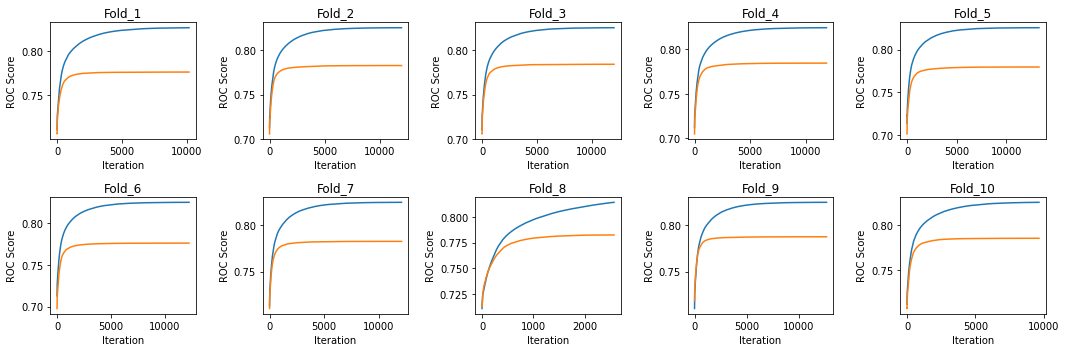

In [ ]:
fig, axes = plt.subplots(2,5, figsize=(15,5))
axes = axes.flatten()

for idx,ax in enumerate(axes, start=1):
  tmp_train = evals_result_train[f'Fold_{idx}']['training']['auc']
  tmp_valid = evals_result_train[f'Fold_{idx}']['valid_1']['auc']
  ax.plot(range(len(tmp_train)), tmp_train)
  ax.plot(range(len(tmp_valid)), tmp_valid)
  ax.set_title(f'Fold_{idx}')
  ax.set_xlabel('Iteration') 
  ax.set_ylabel('ROC Score') 

plt.tight_layout()
plt.show()

In [ ]:
threshs = np.linspace(0,1,100)

scores = {'TN':[],'FP':[],'FN':[],'TP':[],'F1_Score':[],'Precision':[], 'Recall':[]}

for th in threshs:
  y_Pred = app_train_wPreds['SCALED_MEAN_PRED'].apply(lambda x: 0 if x<th else 1)
  y_True = app_train_wPreds['TARGET']
  tn, fp, fn, tp = confusion_matrix(y_True, y_Pred).ravel()
  f1score = f1_score(y_True, y_Pred)
  precisionscore = precision_score(y_True, y_Pred)
  recallscore = recall_score(y_True, y_Pred)
  scores['TN'].append(tn), scores['FP'].append(fp), scores['FN'].append(fn), scores['TP'].append(tp)
  scores['F1_Score'].append(f1score), scores['Precision'].append(precisionscore), scores['Recall'].append(recallscore)

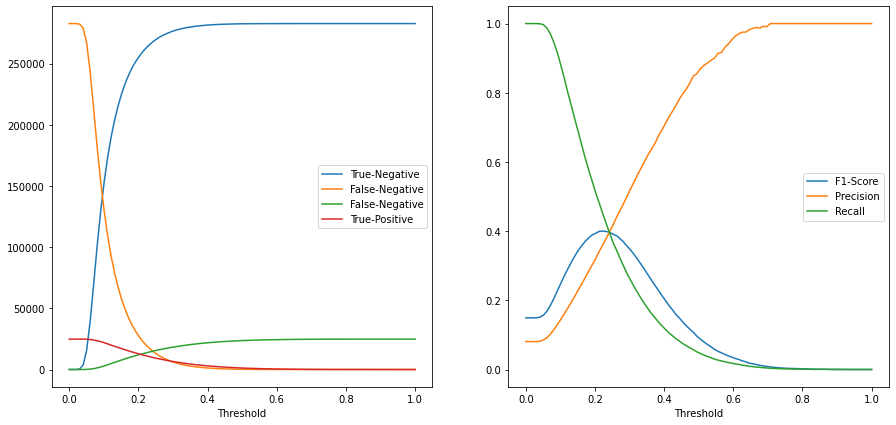

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(15,7))
axes = axes.flatten()

axes[0].plot(threshs, scores['TN'], label='True-Negative') 
axes[0].plot(threshs, scores['FP'], label='False-Negative')
axes[0].plot(threshs, scores['FN'], label='False-Negative') 
axes[0].plot(threshs, scores['TP'], label='True-Positive')
axes[0].set_xlabel('Threshold')
axes[0].legend()

axes[1].plot(threshs, scores['F1_Score'], label='F1-Score') 
axes[1].plot(threshs, scores['Precision'], label='Precision')
axes[1].plot(threshs, scores['Recall'], label='Recall')
axes[1].set_xlabel('Threshold')
axes[1].legend()
plt.show()

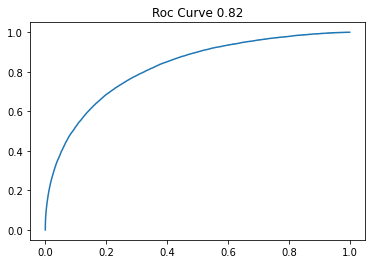

In [ ]:
fpr, tpr, _ = roc_curve(app_train_wPreds['TARGET'], app_train_wPreds['SCALED_MEAN_PRED'])
roc_score = roc_auc_score(app_train_wPreds['TARGET'], app_train_wPreds['SCALED_MEAN_PRED'])

plt.plot(fpr, tpr)
plt.title(f'Roc Curve {round(roc_score, 2)}')
plt.show()

In [ ]:
app_train_wPreds_submission = app_train_X[app_train_X['TARGET'].isnull()].copy()
X_submission = app_train_wPreds_submission.drop(['SK_ID_CURR','TARGET'], axis=1)
for key, model in models_dict.items():
  app_train_wPreds_submission[key] = model.predict(X_submission) 

In [ ]:
app_train_wPreds_submission['TARGET'] = app_train_wPreds_submission[[e for e in app_train_wPreds_submission if 'Fold_' in e]].mean(axis=1)
app_train_wPreds_submission['TARGET'] = MinMaxScaler().fit_transform(app_train_wPreds_submission[['TARGET']])

In [ ]:
submission = app_train_wPreds_submission[['SK_ID_CURR','TARGET']]

In [ ]:
assert submission.shape[0] == pd.read_csv('sample_submission.csv').shape[0]

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
! kaggle competitions submit -c home-credit-default-risk -f submission.csv -m "Message"

100% 1.24M/1.24M [00:04<00:00, 276kB/s]
Successfully submitted to Home Credit Default Risk